<a href="https://colab.research.google.com/github/JUANES31081/PORTAFOLIO_/blob/main/Texto_a_modelo_OpenAI_Point_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Sep 27 20:31:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install plotly -q

In [ ]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 57 (delta 7), reused 51 (delta 7), pack-reused 0
Receiving objects: 100% (57/57), 1.56 MiB | 10.01 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
%cd point-e

/content/point-e


In [ ]:
! pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-j9s65r0y/clip_79848b31604346538c6856a601c0f5a9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-j9s65r0y/clip_79848b31604346538c6856a601c0f5a9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.1 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=74c975899e1c8fe4bbfae14570a4bf7720eb9b817e4cf20f6ef407bf6babe311
  Stored in directory: /tmp/pip-ephem-wheel-cache-84e4pwk7/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.5.0-py

### Imports

In [ ]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

### Models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec' #base-300m base-1b
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|████████████████████████████████████████| 890M/890M [00:09<00:00, 101MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[7.0, 1.0],# cambiar 3*3
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [ ]:
# Set a prompt to condition on.
prompt = 'an animal'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]

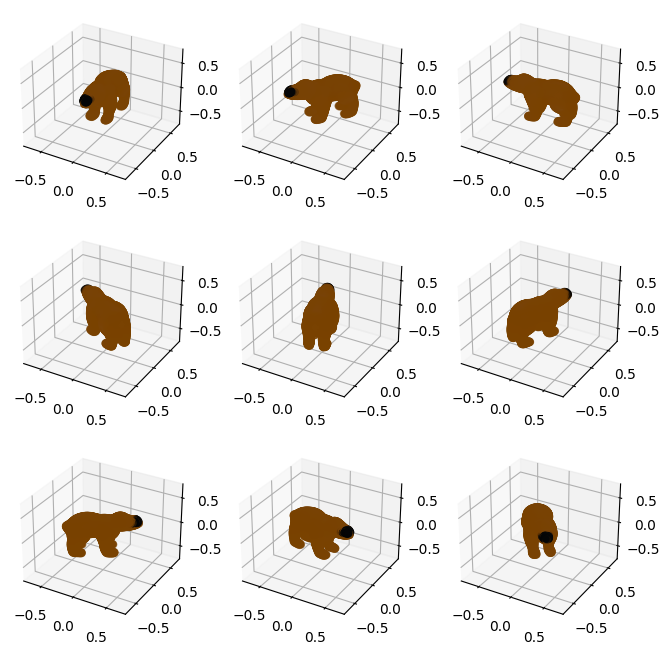

In [ ]:

fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [ ]:
import plotly.graph_objects as go


In [ ]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [ ]:
fig_plotly.show(renderer="colab")


In [ ]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


  0%|          | 0.00/38.0M [00:00<?, ?iB/s]

<All keys matched successfully>

In [ ]:
import skimage.measure as measure


In [ ]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=128, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/512 [00:00<?, ?it/s]

In [ ]:
# Write the mesh to a PLY file to import into some other program.
with open('Animal.ply', 'wb') as f:
    mesh.write_ply(f)

In [ ]:
from traitlets.traitlets import Undefined
import time

prompts=["an AI"] #, "an airplane with thicker wings"]
names = ["animal1.ply"] #,"airplane1.ply"]
start_time = time.time()
for i in range(len(prompts)):
  # Set a prompt to condition on.
  prompt = prompts[i]
  while True:
    # Produce a sample from the model.
    samples = None
    for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
        samples = x
    pc = sampler.output_to_point_clouds(samples)[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('creating SDF model...')
    name = 'sdf'
    model = model_from_config(MODEL_CONFIGS[name], device)
    model.eval()
    print('loading SDF model...')
    model.load_state_dict(load_checkpoint(name, device))
    # Produce a mesh (with vertex colors)
    mesh = marching_cubes_mesh(
        pc=pc,
        model=model,
        batch_size=4096,
        grid_size=128, # increase to 128 for resolution used in evals
        progress=True,
    )
    # Write the mesh to a PLY file to import into some other program.
    with open(names[i], 'wb') as f:
        mesh.write_ply(f)
    break
elapsed_time = time.time() - start_time
print(f"Elapsed time for execution: {elapsed_time} seconds")

0it [00:00, ?it/s]

creating SDF model...
loading SDF model...


  0%|          | 0/512 [00:00<?, ?it/s]

Elapsed time for execution: 73.09400820732117 seconds


In [ ]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )
fig_plotly.show(renderer="colab")